# Аналитика в Яндекс.Афише

## Описание проекта

У нас в распоряжении данные с июня 2017 по конец мая 2018 года:

    лог сервера с данными о посещениях сайта,
    выгрузка всех заказов за этот период,
    статистика рекламных расходов.
    
Задача: 
    
    помочь маркетологам оптимизировать маркетинговые затраты.

Мы изучили:

    как люди пользуются продуктом,
    когда они начинают покупать,
    сколько денег приносит каждый клиент
    когда клиент окупается.


Таблица visits (лог сервера с информацией о посещениях сайта)

* Uid — уникальный идентификатор пользователя
* Device — категория устройства пользователя
* Start Ts — дата и время начала сессии
* End Ts — дата и время окончания сессии
* Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах)

* Uid — уникальный id пользователя, который сделал заказ
* Revenue — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг)

* source_id — идентификатор рекламного источника
* dt — дата
* costs — затраты на этот рекламный источник в этот день

### <a name="7."></a>[Содержание](#7.)

* [1. Получение общей информации, подготовка данных](#1.)
* [2. Построение отчётов и расчет метрик](#2.)
    * [2.1. Продукт](#3.)
    * [2.2. Продажи](#4.)
    * [2.3. Маркетинг](#5.)
* [3. Общий вывод](#6.)


## 1. <a name="1."></a>Получение общей информации, подготовка данных 

In [1]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import math 
from scipy import stats as st
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')

In [3]:
orders = pd.read_csv('/datasets/orders_log.csv')

In [4]:
costs = pd.read_csv('/datasets/costs.csv')

In [5]:
#создадим функцию для вывода информации о данных
def info(data):
    display(data.head(10))
    print(data.info())
    print('Проверка на дубликаты')
    print(data.duplicated().sum())    
    print('Проверка на пропущенные значения')
    print(data.isnull().sum())

In [6]:
info(visits)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None
Проверка на дубликаты
0
Проверка на пропущенные значения
Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64


In [7]:
info(orders)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None
Проверка на дубликаты
0
Проверка на пропущенные значения
Buy Ts     0
Revenue    0
Uid        0
dtype: int64


In [8]:
info(costs)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None
Проверка на дубликаты
0
Проверка на пропущенные значения
source_id    0
dt           0
costs        0
dtype: int64


Переименуем столбцы

In [9]:
visits.columns

Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')

In [10]:
visits.rename(columns={
    'Device': 'device',
    'End Ts': 'session_end_ts',
    'Source Id': 'source_id',
    'Start Ts': 'session_start_ts',
    'Uid': 'Uid'
}, inplace=True)

In [11]:
orders.columns

Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')

In [12]:
orders.rename(columns={
    'Buy Ts': 'buy_ts',
    'Revenue': 'revenue',
    'Uid': 'Uid'
}, inplace=True)

Переведем данные с датой и временеим в формат datetime

In [13]:
visits['session_end_ts'] = pd.to_datetime(visits['session_end_ts'])
visits['session_start_ts'] = pd.to_datetime(visits['session_start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

## <a name="2."></a>2. Построение отчётов и расчет метрик

### <a name="3."></a>2.1. Продукт
[к содержанию](#7.)

**Рассчитаем DAU, WAU, MAU**

In [14]:
visits.head(2)

,device,session_end_ts,source_id,session_start_ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740


Добавим столбцы с годом годом, месяцем, неделей и датой сессии

In [15]:
visits['session_year']  = visits['session_start_ts'].astype('datetime64[Y]')
visits['session_month'] = visits['session_start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['session_start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['session_start_ts'].dt.date 

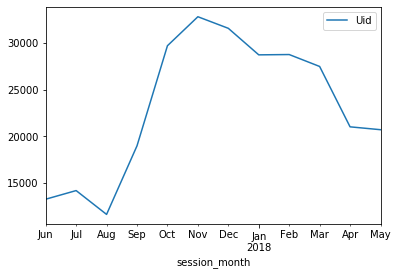

In [16]:
dau_total=visits.groupby(['session_date']).agg({'Uid': 'nunique'}).mean() 
wau_total=visits.groupby(['session_week']).agg({'Uid': 'nunique'}).mean()
mau_total=visits.groupby(['session_month']).agg({'Uid': 'nunique'}).mean()
visits.groupby(['session_month']).agg({'Uid': 'nunique'}).plot()
# группировка по дню, неделе, месяцу с расчетом количества пользователей

В ноябре наблюдается пик, после идет снижение числа полизователей. Пик вероятно связан с акцией.

In [17]:
print('Количество уникальных пользователей в день или DAU: {}'.format(int(dau_total))) 
print('Количество уникальных пользователей в неделю или WAU: {}'.format(int(wau_total)))
print('Количество уникальных пользователей в месяц или MAU: {}'.format(int(mau_total)))
#вывод значений DAU,WAU,MAU и преобразование в целое

Количество уникальных пользователей в день или DAU: 907
Количество уникальных пользователей в неделю или WAU: 5724
Количество уникальных пользователей в месяц или MAU: 23228


**Рассчитаем число сессий в месяц**

In [18]:
dau_monthly = []
month_list = []

for month, df in visits.groupby('session_month'):
    dau_tmp = df.groupby('session_date').agg({'Uid': 'count'}).mean()
    month_list.append(month.strftime('%Y-%m'))
    dau_monthly.append(int(dau_tmp))

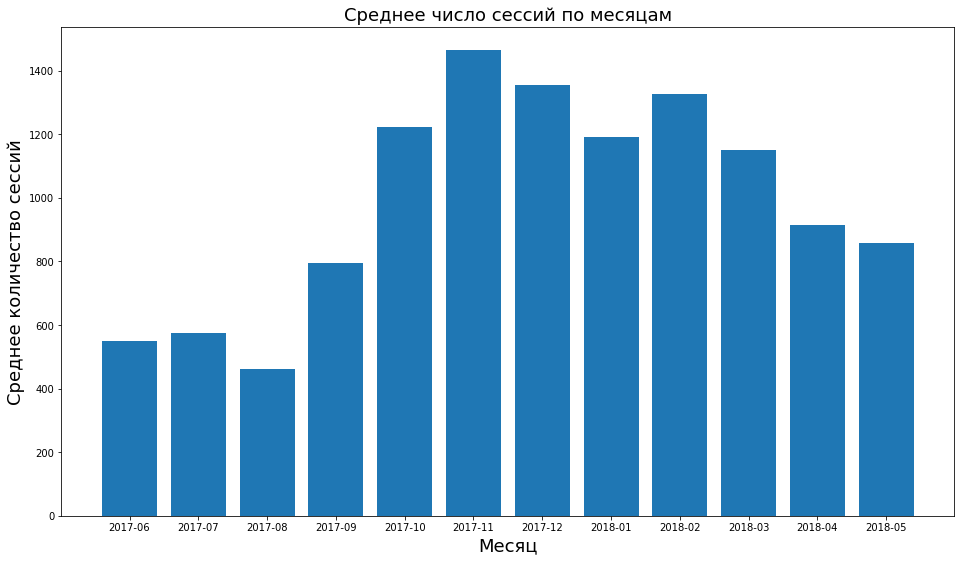

In [19]:
plt.figure(figsize=(16,9))
plt.bar(month_list, dau_monthly)

plt.xlabel('Месяц', fontsize = 18)
plt.ylabel('Среднее количество сессий', fontsize = 18)
plt.title('Среднее число сессий по месяцам', fontsize = 18)

plt.show()

До ноября 17 года число сессий в месяц росло, потом начало падать.

**Рассчитаем число сессий в день**

In [20]:
sessions_per_user = visits.groupby('session_date').agg({'Uid': ['count','nunique']}) 

In [21]:
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
#переименование названий столбцов

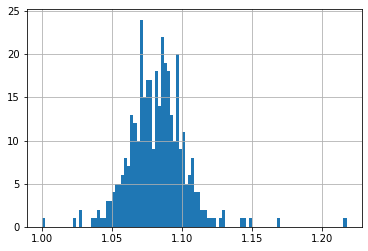

In [22]:
sessions_per_user['sess_per_user'].hist(bins=100) #гистограмма сессий

Распределение стремится к нормальному. Расчитаем среднее значение количества сесcий в день

In [23]:
sessions_per_user = sessions_per_user['sess_per_user'].mean() 
#расчет среднего количества сессий на 1 пользователя в день

In [24]:
print('Количество сессий на одного пользователя в день: {0:.2f}'.format(sessions_per_user))

Количество сессий на одного пользователя в день: 1.08


**Определим продолжительность сессии**

In [25]:
visits['session_duration_sec'] = (visits['session_end_ts'] - visits['session_start_ts']).dt.seconds
#расчет продолжительности сессии 

In [26]:
visits['session_duration_sec'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

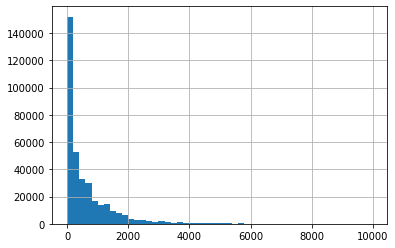

In [27]:
visits[visits['session_duration_sec'] < 10000]['session_duration_sec'].hist(bins=50)

Почти все значения близки к 0. Исходя из распределения, рассчитаем моду (значение в выборке, которое встречается чаще всего)

In [28]:
asl=visits['session_duration_sec'].mode()[0]

In [29]:
print('Средняя продолжительность сессии или ASL: {} секунд'.format(asl))

Средняя продолжительность сессии или ASL: 60 секунд


**Определим регулярность посещения сайтов**

In [30]:
sticky_mau=dau_total/mau_total*100
sticky_wau=dau_total/wau_total*100

In [31]:
print('Регулярность посещения сайта в месяц составляет (sticky factor): {}%'.format(int(sticky_mau)))
print('Регулярность посещения сайта в неделю составляет (sticky factor): {}%'.format(int(sticky_wau)))


Регулярность посещения сайта в месяц составляет (sticky factor): 3%
Регулярность посещения сайта в неделю составляет (sticky factor): 15%


In [32]:
visits.head(3)

,device,session_end_ts,source_id,session_start_ts,Uid,session_year,session_month,session_week,session_date,session_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,0


**Посчитаем как часто люди возвращаются на сайт (retention rate)**

Определим дату, когда пользователь впервые проявил активность

In [33]:
first_session_date = visits.groupby('Uid')['session_start_ts'].min()
first_session_date.name = 'first_session_date'
visits = visits.join(first_session_date, on='Uid')

Рассчитаем lifetime пользователя в рамках когорты

In [34]:
visits['first_session_month'] = visits['first_session_date'].astype('datetime64[M]')
visits['session_month'] = visits['session_start_ts'].astype('datetime64[M]')
visits['cohort_lifetime'] = visits['session_month'] - visits['first_session_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

Рассчитаем для каждой когорты количество активных пользователей

In [35]:
cohorts = visits.groupby(['first_session_month', 'cohort_lifetime']).agg({'Uid': 'nunique'}).reset_index()

Рассчитаем исходное количество пользователей в когорте

In [36]:
initial_users_count = cohorts[cohorts['cohort_lifetime']==0][['first_session_month', 'Uid']]
initial_users_count = initial_users_count.rename(columns={'Uid': 'cohort_users'})

Рассчитаем Retention Rate

In [37]:
cohorts = cohorts.merge(initial_users_count, on='first_session_month')
cohorts['retention'] = cohorts['Uid'] / cohorts['cohort_users']
cohorts['first_session_month'] = cohorts['first_session_month'].dt.strftime('%Y.%m.%d')


In [38]:
#сводная таблица
retention_pivot = cohorts.pivot_table(index='first_session_month', columns='cohort_lifetime',
                                      values='retention', aggfunc='sum')

In [39]:
retention_pivot.index = pd.to_datetime(retention_pivot.index).strftime('%Y-%m').astype('str')

Построим хитмэп

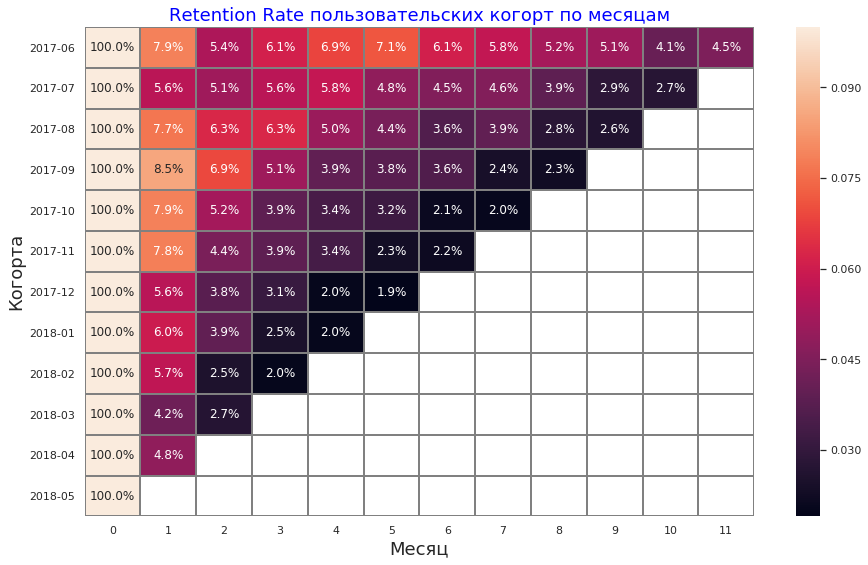

In [40]:
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.1)

plt.xlabel('Месяц', fontsize = 18)
plt.ylabel('Когорта', fontsize = 18)
plt.title('Retention Rate пользовательских когорт по месяцам', fontsize = 18, color='blue')

plt.show()

- По всем когортам наблюдается общее снижение Retention Rate
- Наиболее высокий Retention Rate у первой когоры, плюс в 12 месяце зафиксирован рост

In [41]:
for i in range(1,7):
    print('В среднем в {} месяц возвращается {:.2%} людей'.format(i, retention_pivot[i].mean()))

В среднем в 1 месяц возвращается 6.52% людей
В среднем в 2 месяц возвращается 4.63% людей
В среднем в 3 месяц возвращается 4.28% людей
В среднем в 4 месяц возвращается 4.06% людей
В среднем в 5 месяц возвращается 3.94% людей
В среднем в 6 месяц возвращается 3.70% людей


### 2.1. Вывод

- Количество уникальных пользователей в день или DAU: 907
- Количество уникальных пользователей в неделю или WAU: 5825
- Количество уникальных пользователей в месяц или MAU: 23228
- Количество сессий на одного пользователя в день: 1
- Средняя продолжительность сессии или ASL: 60 секунд
- Регулярность посещения сайта в месяц составляет (sticky factor): 3%
- Регулярность посещения сайта в неделю составляет (sticky factor): 15%
- По всем когортам наблюдается общее снижение Retention Rate
- Наиболее высокий Retention Rate у первой когоры, в 12 месяце зафиксирован рост
- В среднем в 1 месяц возвращается 6.52% пользователей.

### <a name="4."></a>2.2. Продажи
[к содержанию](#7.)

**Определим когда люди начинают покупать**

In [42]:
orders.head(3)

,buy_ts,revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844


По каждому клиенту получим дату его первого заказа

In [43]:
first_order_date_by_customers = orders.groupby('Uid')['buy_ts'].min()
first_order_date_by_customers.name = 'first_order_date'
orders = orders.join(first_order_date_by_customers, on='Uid')

Объединим первые заказы и сессии

In [44]:
visits_orders = orders.join(first_session_date, on='Uid')

Время от сессии до покупки сохраним в столбце time_delta

In [45]:
visits_orders['time_delta'] = visits_orders['first_order_date'] - visits_orders['first_session_date']
visits_orders['time_delta'] = visits_orders['time_delta'] / np.timedelta64(1,'m')
visits_orders['time_delta'] = visits_orders['time_delta'].round().astype('int')

In [46]:
visits_orders['time_delta'].describe()

count     50415.000000
mean      25368.990618
std       66910.801873
min           0.000000
25%           4.000000
50%          22.000000
75%        6231.000000
max      523144.000000
Name: time_delta, dtype: float64

Медианное значение времени от первой сессии покупки до составляет 22 минуты.

**Определим сколько раз покупают за месяц**

In [47]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['first_order_month'] = orders['first_order_month'].dt.strftime('%Y.%m.%d')
orders['order_month'] = orders['order_month'].dt.strftime('%Y.%m.%d')

In [48]:
orders_pivot = orders.pivot_table(
    index='first_order_month',  
    columns='order_month',  
    values='revenue', 
    aggfunc='count')

In [49]:
orders_pivot.index = pd.to_datetime(orders_pivot.index).strftime('%Y-%m').astype('str')

На основе сводной таблицы выведем хитмэп

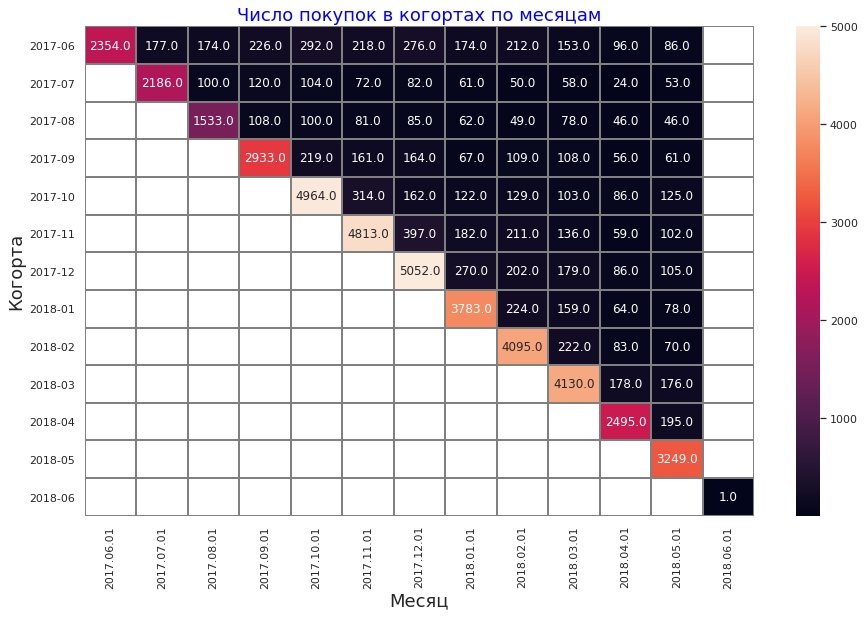

In [50]:
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Buy per month')
sns.heatmap(orders_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmax=5000)

plt.xlabel('Месяц', fontsize = 18)
plt.ylabel('Когорта', fontsize = 18)
plt.title('Число покупок в когортах по месяцам', fontsize = 18, color='blue')

plt.show()

После первого месяца число покупок падает примерно в 10, после происходит общее плавное сокращение числа покупок с небольшими всплесками.  

**Определим средний чек**

Cгруппируем данные по когорте и месяцу совершения заказа 

In [51]:
orders_grouped = orders.pivot_table(
    index=['first_order_month','order_month'],
    values='revenue',
    aggfunc=['sum','count'])

#найдём средний чек 
orders_grouped['revenue_per_user'] = orders_grouped['sum'] / orders_grouped['count']

Построим сводную таблицу изменения среднего чека

In [52]:
orders_ticket = orders_grouped.pivot_table(
    index='first_order_month',
    columns='order_month',
    values='revenue_per_user',
    aggfunc='mean').round(2)


In [53]:
orders_ticket.index = pd.to_datetime(orders_ticket.index).strftime('%Y-%m').astype('str')

Выведем хитмэп

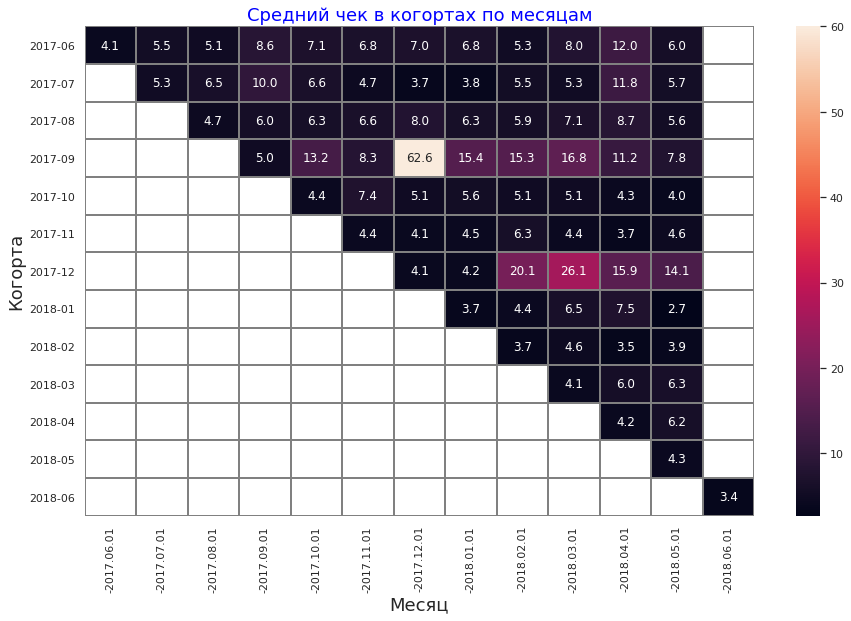

In [54]:
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Average ticket')
sns.heatmap(orders_ticket, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmax=60)

plt.xlabel('Месяц', fontsize = 18)
plt.ylabel('Когорта', fontsize = 18)
plt.title('Средний чек в когортах по месяцам', fontsize = 18, color='blue')

plt.show()

В отличие от количества покупок в месяц, средний чек после первого месяца растет во всех когортах. У сентябрьской когорты наблюдается аномально высокий чек в декабре.

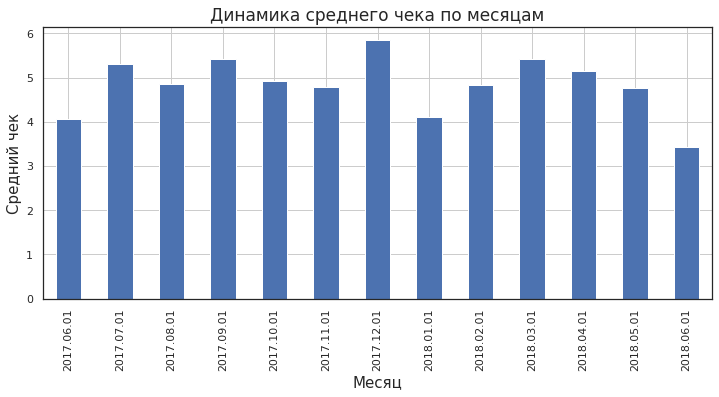

In [55]:
#найдем выручку за каждый месяц и количество покупок nunique
mean_revenue = orders.groupby(
    'order_month').agg({'revenue':'sum','buy_ts':'count'})

#посчитаем средний чек в когортах
mean_revenue['one_purchase'] = mean_revenue['revenue'] / mean_revenue['buy_ts']


mean_revenue['one_purchase'].plot.bar(grid=True, figsize=(12, 5))
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Средний чек', fontsize=15)
plt.title('Динамика среднего чека по месяцам', fontsize=17)

plt.show()

In [56]:
print('Средний чек составляет: {:.2f}'.format(mean_revenue['one_purchase'].mean()))

Средний чек составляет: 4.84


**Расчет общего LTV**

In [57]:
orders.head(3)

,buy_ts,revenue,Uid,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017.06.01,2017.06.01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017.06.01,2017.06.01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017.06.01,2017.06.01


Посчитаем количество новых покупателей за каждый месяц

In [58]:
cohort_sizes = orders.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
#print(cohort_sizes.head())

Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку

In [59]:
cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
#print(cohorts.head())

In [60]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
#объединим таблицы

Посчитаем ltv и возраст когорт

In [61]:
report['ltv'] = report['revenue'] / report['n_buyers']

In [62]:
report.head(3)

,first_order_month,n_buyers,order_month,revenue,ltv
0,2017.06.01,2023,2017.06.01,9557.49,4.724414
1,2017.06.01,2023,2017.07.01,981.82,0.485329
2,2017.06.01,2023,2017.08.01,885.34,0.437637


In [63]:
report['first_order_month'] = report['first_order_month'].astype('datetime64[M]')
report['order_month'] = report['order_month'].astype('datetime64[M]')
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

In [64]:
report['first_order_month'] = report['first_order_month'].dt.strftime('%Y.%m.%d')
report['order_month'] = report['order_month'].dt.strftime('%Y.%m.%d')
#print(report.head())

Визуализируем когорты в хитмэп

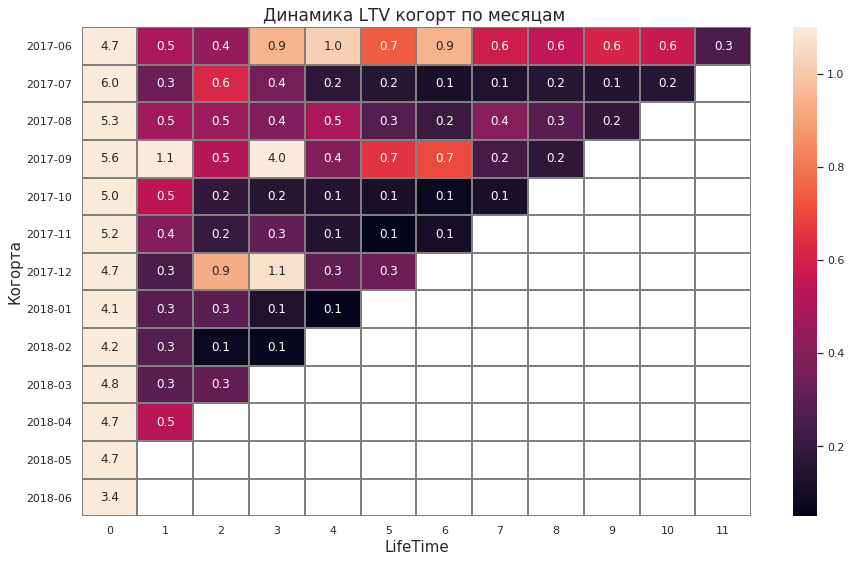

In [65]:
orders_output = report.pivot_table(
        index='first_order_month',
        columns='age',
        values='ltv',
        aggfunc='mean').round(2)
orders_out = orders_output
orders_out.index = pd.to_datetime(orders_out.index).strftime('%Y-%m').astype('str')
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('LTV')
sns.heatmap(orders_out, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmax=1.1)

plt.xlabel('LifeTime', fontsize=15)
plt.ylabel('Когорта', fontsize=15)
plt.title('Динамика LTV когорт по месяцам ', fontsize=17)

plt.show()

**Проанализируем когорты за 6 месяцев**

,ltv
first_order_month,
2017.06.01,8.36
2017.07.01,7.66
2017.08.01,7.38
2017.09.01,12.31
2017.10.01,6.16
2017.11.01,6.28


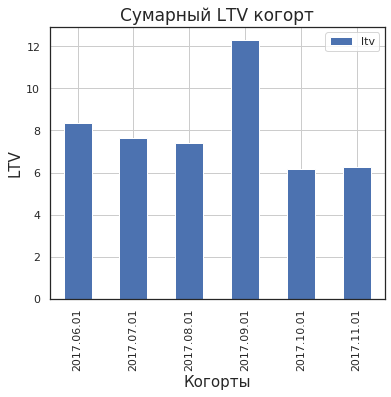

In [66]:
orders_6_months = report.query('age < 6 and first_order_month < "2017.12.01"').pivot_table(
        index='first_order_month',
        values='ltv',
        aggfunc='sum').round(2)
display(orders_6_months)
orders_6_months.plot(grid=True, kind='bar', figsize=(6,5), title='ltv')

plt.xlabel('Когорты', fontsize=15)
plt.ylabel('LTV', fontsize=15)
plt.title('Сумарный LTV когорт', fontsize=17)

plt.show()

Максимальная выручка за 6 месяцев у сентябрьской когорты (12.3), на втором месте июньская когорта (8.4)

In [67]:
z=orders_6_months['ltv'].mean()
print('средний LTV за 6 месяцев: {}'.format(z))

средний LTV за 6 месяцев: 8.025


**Расчитаем суммарную выручку (оборот)**

In [68]:
report['gp'] = report['revenue'] 
tot_rev=report['revenue'].sum()

In [69]:
print('Оборот составляет : {:.2f}'.format(tot_rev))

Оборот составляет : 252057.20


### 2.2. Вывод

- Медианное значение времени от первой сессии покупки до составляет 22 минуты,
- Средний чек составляет 4.84,
- Максимальная выручка за 6 месяцев у сентябрьской когорты (12.3), на втором месте июньская когорта (8.4),
- Оборот составляет : 252057.20,
- Cредний LTV за 6 месяцев: 8.025

### <a name="5."></a>2.3. Маркетинг
[к содержанию](#7.)

Определим сколько денег потратили: всего, на каждый источник, по времени

In [70]:
#определим расходы за каждый месяц и в целом за период
costs['costs_month'] = costs['dt'].astype('datetime64[M]')
costs['costs_month'] = costs['costs_month'].dt.strftime('%Y.%m.%d')
costs_pivot = costs.pivot_table(
    index='costs_month',    
    values='costs', 
    aggfunc='sum')
display(costs_pivot)
display(costs_pivot.sum())

,costs
costs_month,
2017.06.01,18015.00
2017.07.01,18240.59
2017.08.01,14790.54
2017.09.01,24368.91
2017.10.01,36322.88
2017.11.01,37907.88
2017.12.01,38315.35
2018.01.01,33518.52
2018.02.01,32723.03


costs    329131.62
dtype: float64

Построим график с месячными расходами

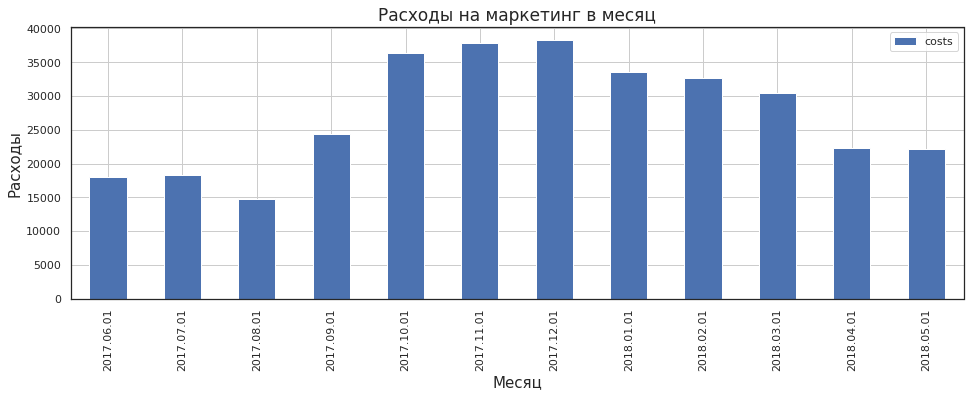

In [71]:
costs_pivot.plot(grid=True, kind='bar', figsize=(16,5),  title='monthly costs sum')

plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Расходы', fontsize=15)
plt.title('Расходы на маркетинг в месяц', fontsize=17)

plt.show()

- До декабря расходы на маркетинг росли, далее начали снижатся,
- совокупные затраты на маркетинг составляют 329 131.62

**Определим сколько денег потратили на каждый источник**

In [72]:
source_pivot = costs.pivot_table(
    index='source_id',
    values='costs', 
    aggfunc='sum')
display(source_pivot)

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


Составим диаграмму с расходами, приходящимися на каждый источник

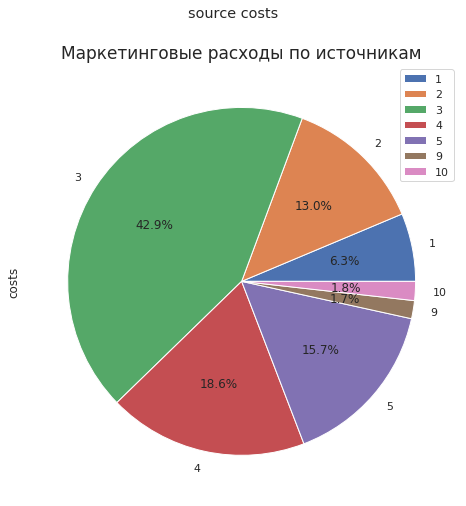

In [73]:
source_pivot.plot(kind='pie', figsize=(10,8), subplots=True, autopct='%1.1f%%', title='source costs')
plt.title('Маркетинговые расходы по источникам', fontsize=17)
plt.show()

Наибольшие затраты (141321.63), составляющие почти половину всех затрат на маркетинг, направлены на рекламный источник с идентификатором 3 

Визуализируем расходы по источникам в течении всего периода

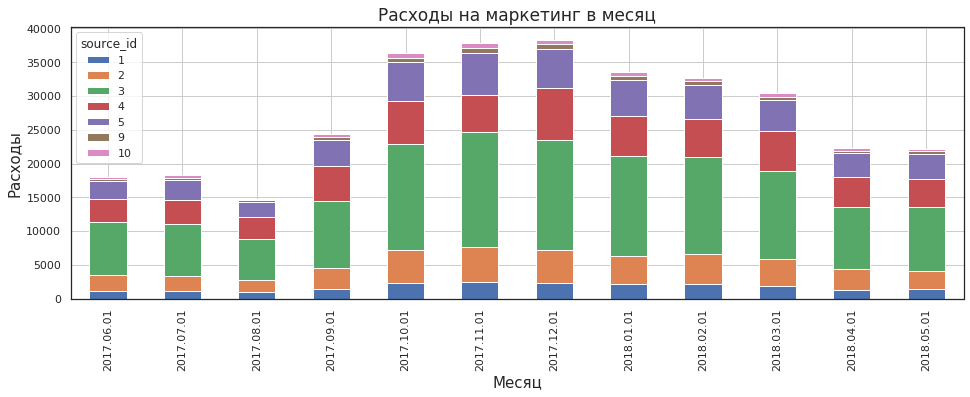

In [74]:
source_monthly_pivot = costs.pivot_table(
    index='costs_month',
    columns='source_id',
    values='costs', 
    aggfunc='sum')
source_monthly_pivot.plot(grid=True, kind='bar', stacked=True, figsize=(16,5),  title='Source by Months')


plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Расходы', fontsize=15)
plt.title('Расходы на маркетинг в месяц', fontsize=17)

plt.show()

**Посчитаем сколько стоило привлечение одного покупателя из каждого источника**

Сгруппируем затраты по месяцу и источнику

In [75]:
source_costs = costs.groupby(['costs_month', 'source_id']).sum().reset_index()

In [76]:
#выделим покупателей по каналам и месяцам по первому источнику
visits_sorted = visits.sort_values(by='session_start_ts').reset_index()
first_source = visits.groupby('Uid').agg({'source_id': 'first'})
client_per_source = orders.merge(first_source, on='Uid').reset_index()
source_clients_month = client_per_source.groupby(['first_order_month', 'source_id']).agg({'Uid':'nunique'})

In [77]:
report_new = pd.merge(source_costs, source_clients_month, left_on=['costs_month','source_id'], right_on=['first_order_month','source_id'])
report_new['cac'] = report_new['costs'] / report_new['Uid'] 
report_new['cac'] = report_new['cac'].round(2)
display(report_new.head())

,costs_month,source_id,costs,Uid,cac
0,2017.06.01,1,1125.61,203,5.54
1,2017.06.01,2,2427.38,271,8.96
2,2017.06.01,3,7731.65,574,13.47
3,2017.06.01,4,3514.80,417,8.43
4,2017.06.01,5,2616.12,368,7.11


Рассчитаем среднюю стоимость привлеченния покупателя

In [78]:
cac_pivot_mean = report_new.pivot_table(
    index='source_id',
    values='cac', 
    aggfunc='mean')

In [79]:
cac_pivot_mean.round(2).sort_values(by='cac', ascending=False)

,cac
source_id,
3,15.88
2,10.09
5,7.55
4,6.69
1,5.60
10,5.26
9,4.30


- Наиболее высокая стоимость привлечения из 3 источника (15.88)
- У 9 и 10 источников стоимость привлечения клиентов почти в 3 раза ниже чем у 1 источника, **4.3** и **5.2** соответсвенно

Визуализируем САС в динамике по когортам

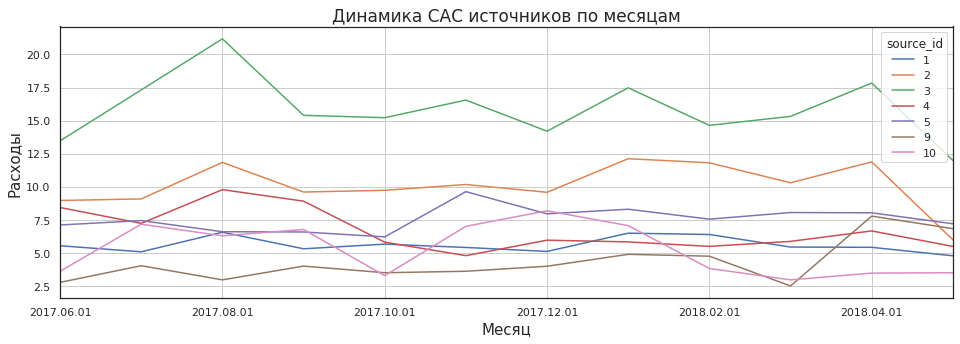

In [80]:
cac_pivot = report_new.pivot_table(
    index='costs_month',
    columns='source_id',
    values='cac', 
    aggfunc='mean')
cac_pivot.plot(grid=True, kind='line', figsize=(16,5),  title='CAC by Source')

plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Расходы', fontsize=15)
plt.title('Динамика CAC источников по месяцам', fontsize=17)

plt.show()

По всем когортам 3 источник самый дорогой, максимальный пик в августовской когорте


**Рассчет LTV каждого источника, результаты используем для рассчета ROI**

In [81]:
#client_per_source

Составим таблицу final, обьединив client_per_source и costs

In [82]:
client_per_source['order_date'] = client_per_source['first_order_date'].dt.date
costs['order_date'] = costs['dt'].dt.date
final=client_per_source.merge(costs, on=['source_id', 'order_date'])
#final

In [83]:
final=final[['source_id', 'Uid', 'order_date', 'first_order_month', 'order_month', 'costs', 'revenue']]
#final

In [84]:
final['source_id'].unique()

array([ 1,  2,  3,  5,  9,  4, 10])

,ltv
first_order_month,
2017.06.01,19.00
2017.07.01,14.92
2017.08.01,7.46
2017.09.01,12.05
2017.10.01,8.35
2017.11.01,7.47


11.54166666666667

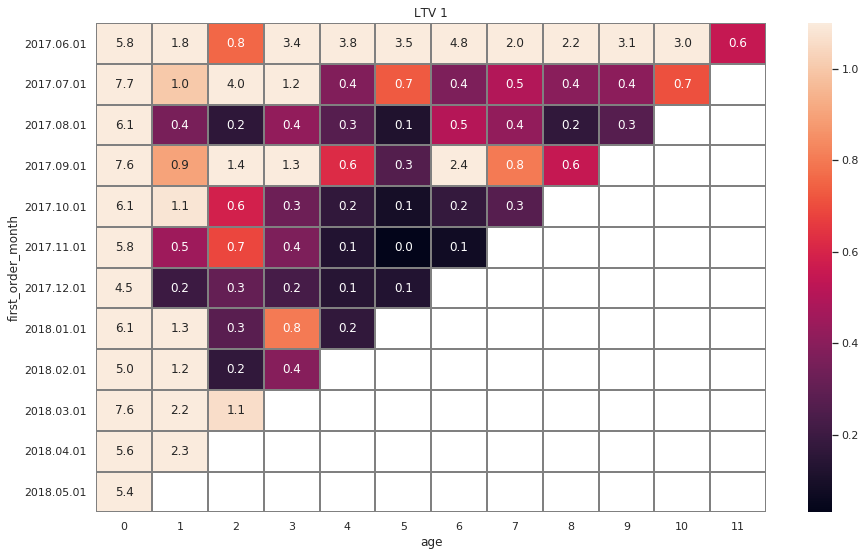

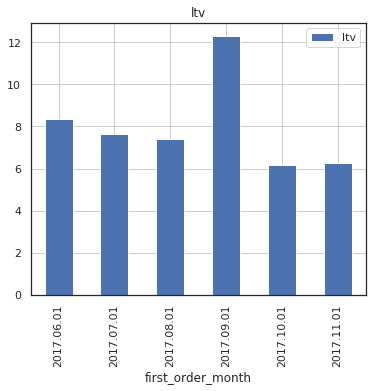

In [85]:
#срез по источнику 1
S1= final.query('source_id == "1"')

#посчитаем количество новых покупателей за каждый месяц
cohort_sizes = S1.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
#print(cohort_sizes.head())

#cгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
cohorts = S1.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
#print(cohorts.head())

#сгруппируем данные
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
#print(report.head())

#посчитаем ltv и возраст когорт
report['ltv'] = report['revenue'] / report['n_buyers']
report['first_order_month'] = report['first_order_month'].astype('datetime64[M]')
report['order_month'] = report['order_month'].astype('datetime64[M]')
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['first_order_month'] = report['first_order_month'].dt.strftime('%Y.%m.%d')
report['order_month'] = report['order_month'].dt.strftime('%Y.%m.%d')
#визуализируем когорты в виде сводной таблицы и построим график
orders_output = report.pivot_table(
        index='first_order_month',
        columns='age',
        values='ltv',
        aggfunc='mean').round(2)

sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('LTV 1')
sns.heatmap(orders_output, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmax=1.1)

#проанализируем когорты за 6 месяцев
orders_6_months.plot(grid=True, kind='bar', figsize=(6,5), title='ltv')
orders_6_months = report.query('age < 6 and first_order_month < "2017.12.01"').pivot_table(
        index='first_order_month',
        values='ltv',
        aggfunc='sum').round(2)
display(orders_6_months)
LTV1=float(orders_6_months.mean())
LTV1

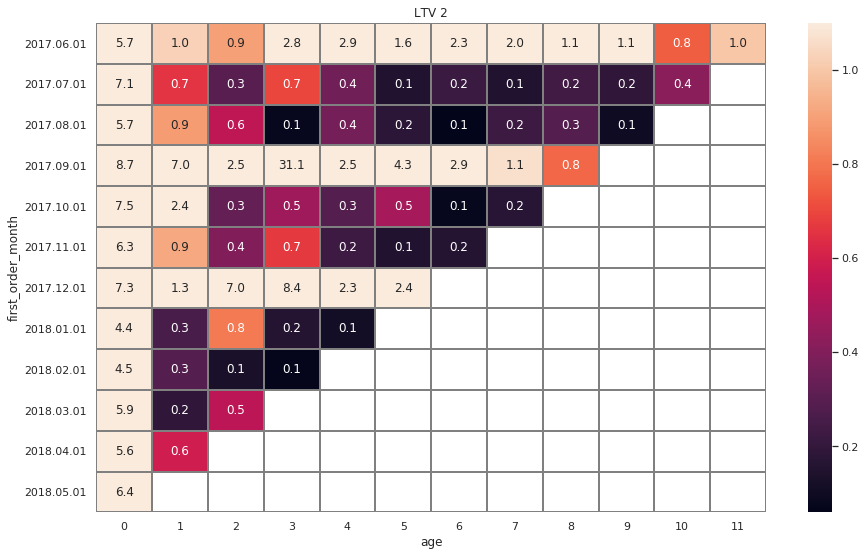

,ltv
first_order_month,
2017.06.01,14.93
2017.07.01,9.29
2017.08.01,7.79
2017.09.01,56.18
2017.10.01,11.42
2017.11.01,8.70


18.051666666666666

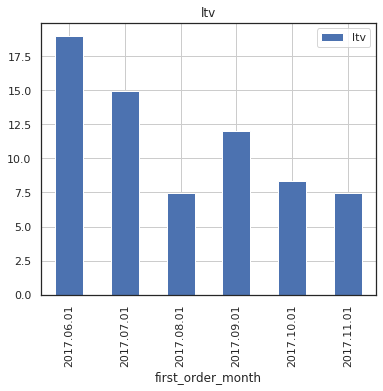

In [86]:
#срез по источнику 2
S1= final.query('source_id == "2"')

#посчитаем количество новых покупателей за каждый месяц
cohort_sizes = S1.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
#print(cohort_sizes.head())

#cгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
cohorts = S1.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
#print(cohorts.head())

#сгруппируем данные
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
#print(report.head())

#посчитаем ltv и возраст когорт
report['ltv'] = report['revenue'] / report['n_buyers']
report['first_order_month'] = report['first_order_month'].astype('datetime64[M]')
report['order_month'] = report['order_month'].astype('datetime64[M]')
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['first_order_month'] = report['first_order_month'].dt.strftime('%Y.%m.%d')
report['order_month'] = report['order_month'].dt.strftime('%Y.%m.%d')
#визуализируем когорты в виде сводной таблицы и построим график
orders_output = report.pivot_table(
        index='first_order_month',
        columns='age',
        values='ltv',
        aggfunc='mean').round(2)

sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('LTV 2')
sns.heatmap(orders_output, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmax=1.1)
plt.show()
#проанализируем когорты за 6 месяцев
orders_6_months.plot(grid=True, kind='bar', figsize=(6,5), title='ltv')
orders_6_months = report.query('age < 6 and first_order_month < "2017.12.01"').pivot_table(
        index='first_order_month',
        values='ltv',
        aggfunc='sum').round(2)
display(orders_6_months)
LTV2=float(orders_6_months.mean())
LTV2

,ltv
first_order_month,
2017.06.01,5.03
2017.07.01,5.58
2017.08.01,6.11
2017.09.01,5.31
2017.10.01,4.96
2017.11.01,5.68


5.445

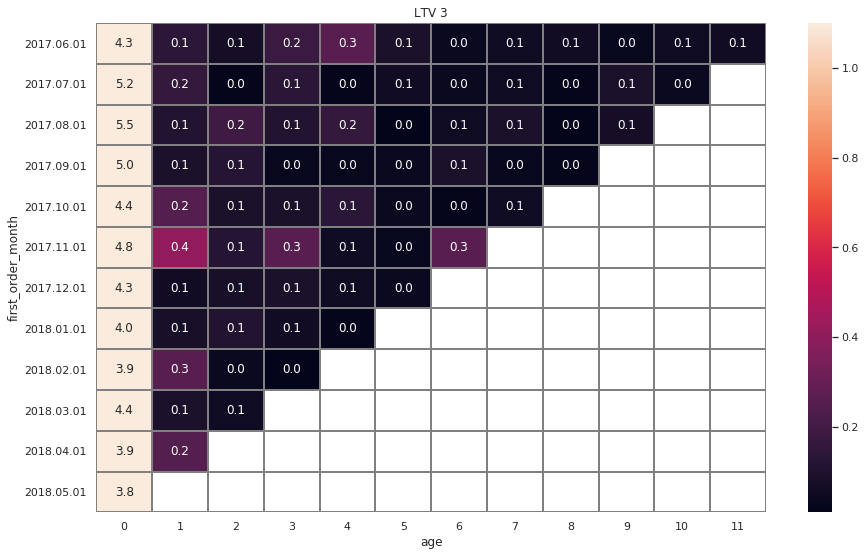

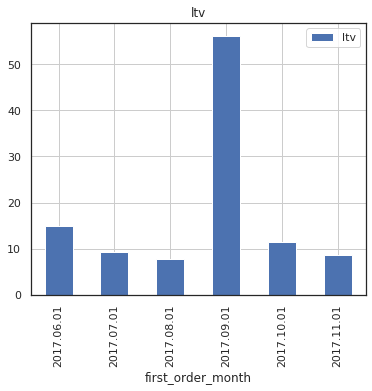

In [87]:
#срез по источнику 3
S1= final.query('source_id == "3"')

#посчитаем количество новых покупателей за каждый месяц
cohort_sizes = S1.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
#print(cohort_sizes.head())

#cгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
cohorts = S1.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
#print(cohorts.head())

#сгруппируем данные
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
#print(report.head())

#посчитаем ltv и возраст когорт
report['ltv'] = report['revenue'] / report['n_buyers']
report['first_order_month'] = report['first_order_month'].astype('datetime64[M]')
report['order_month'] = report['order_month'].astype('datetime64[M]')
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['first_order_month'] = report['first_order_month'].dt.strftime('%Y.%m.%d')
report['order_month'] = report['order_month'].dt.strftime('%Y.%m.%d')
#визуализируем когорты в виде сводной таблицы и построим график
orders_output = report.pivot_table(
        index='first_order_month',
        columns='age',
        values='ltv',
        aggfunc='mean').round(2)

sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('LTV 3')
sns.heatmap(orders_output, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmax=1.1)


#проанализируем когорты за 6 месяцев
orders_6_months.plot(grid=True, kind='bar', figsize=(6,5), title='ltv')
orders_6_months = report.query('age < 6 and first_order_month < "2017.12.01"').pivot_table(
        index='first_order_month',
        values='ltv',
        aggfunc='sum').round(2)
display(orders_6_months)
LTV3=float(orders_6_months.mean())
LTV3

,ltv
first_order_month,
2017.06.01,5.62
2017.07.01,7.18
2017.08.01,6.32
2017.09.01,6.07
2017.10.01,5.09
2017.11.01,6.40


6.113333333333333

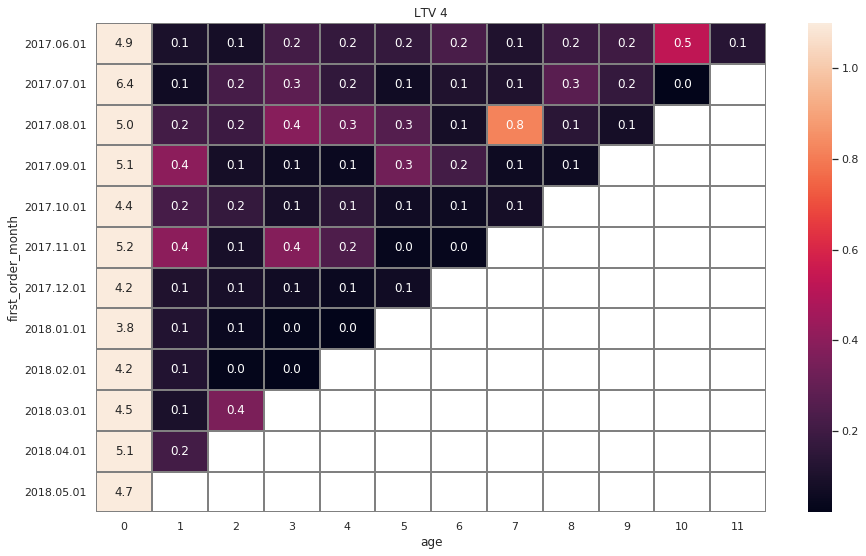

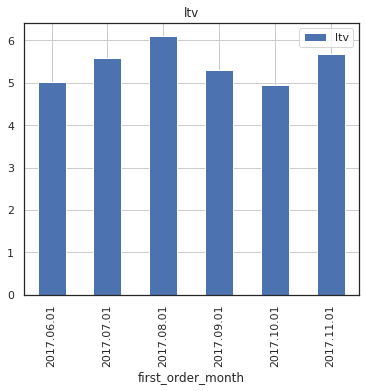

In [88]:
#срез по источнику 4
S1= final.query('source_id == "4"')

#посчитаем количество новых покупателей за каждый месяц
cohort_sizes = S1.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
#print(cohort_sizes.head())

#cгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
cohorts = S1.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
#print(cohorts.head())

#сгруппируем данные
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
#print(report.head())

#посчитаем ltv и возраст когорт
report['ltv'] = report['revenue'] / report['n_buyers']
report['first_order_month'] = report['first_order_month'].astype('datetime64[M]')
report['order_month'] = report['order_month'].astype('datetime64[M]')
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['first_order_month'] = report['first_order_month'].dt.strftime('%Y.%m.%d')
report['order_month'] = report['order_month'].dt.strftime('%Y.%m.%d')
#визуализируем когорты в виде сводной таблицы и построим график
orders_output = report.pivot_table(
        index='first_order_month',
        columns='age',
        values='ltv',
        aggfunc='mean').round(2)

sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('LTV 4')
sns.heatmap(orders_output, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmax=1.1)


#проанализируем когорты за 6 месяцев
orders_6_months.plot(grid=True, kind='bar', figsize=(6,5), title='ltv')
orders_6_months = report.query('age < 6 and first_order_month < "2017.12.01"').pivot_table(
        index='first_order_month',
        values='ltv',
        aggfunc='sum').round(2)
display(orders_6_months)
LTV4=float(orders_6_months.mean())
LTV4

,ltv
first_order_month,
2017.06.01,8.57
2017.07.01,6.21
2017.08.01,9.43
2017.09.01,5.47
2017.10.01,5.92
2017.11.01,4.97


6.761666666666667

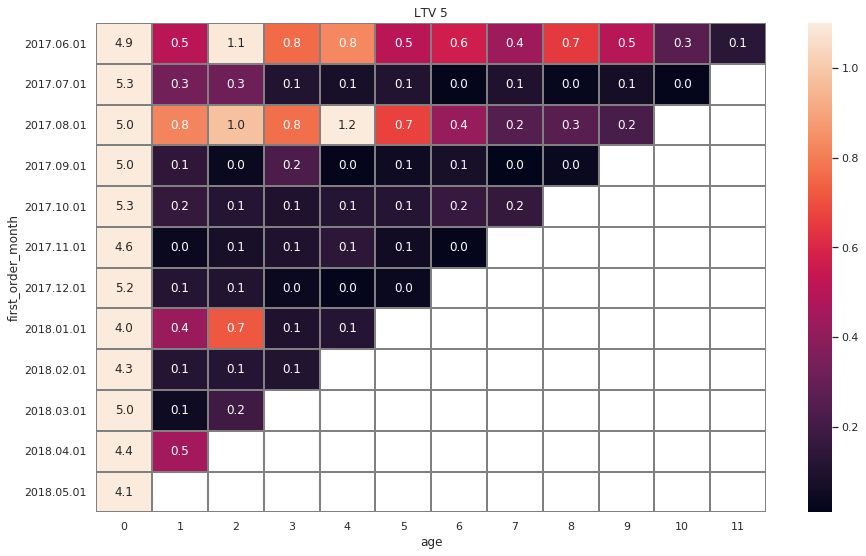

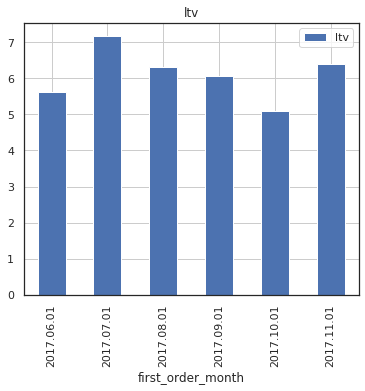

In [89]:
#срез по источнику 5
S1= final.query('source_id == "5"')

#посчитаем количество новых покупателей за каждый месяц
cohort_sizes = S1.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
#print(cohort_sizes.head())

#cгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
cohorts = S1.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
#print(cohorts.head())

#сгруппируем данные
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
#print(report.head())

#посчитаем ltv и возраст когорт
report['ltv'] = report['revenue'] / report['n_buyers']
report['first_order_month'] = report['first_order_month'].astype('datetime64[M]')
report['order_month'] = report['order_month'].astype('datetime64[M]')
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['first_order_month'] = report['first_order_month'].dt.strftime('%Y.%m.%d')
report['order_month'] = report['order_month'].dt.strftime('%Y.%m.%d')
#визуализируем когорты в виде сводной таблицы и построим график
orders_output = report.pivot_table(
        index='first_order_month',
        columns='age',
        values='ltv',
        aggfunc='mean').round(2)
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('LTV 5')
sns.heatmap(orders_output, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmax=1.1)

#проанализируем когорты за 6 месяцев
orders_6_months.plot(grid=True, kind='bar', figsize=(6,5), title='ltv')
orders_6_months = report.query('age < 6 and first_order_month < "2017.12.01"').pivot_table(
        index='first_order_month',
        values='ltv',
        aggfunc='sum').round(2)
display(orders_6_months)
LTV5=float(orders_6_months.mean())
LTV5

,ltv
first_order_month,
2017.06.01,4.07
2017.07.01,7.52
2017.08.01,8.02
2017.09.01,5.02
2017.10.01,4.89
2017.11.01,4.84


5.726666666666667

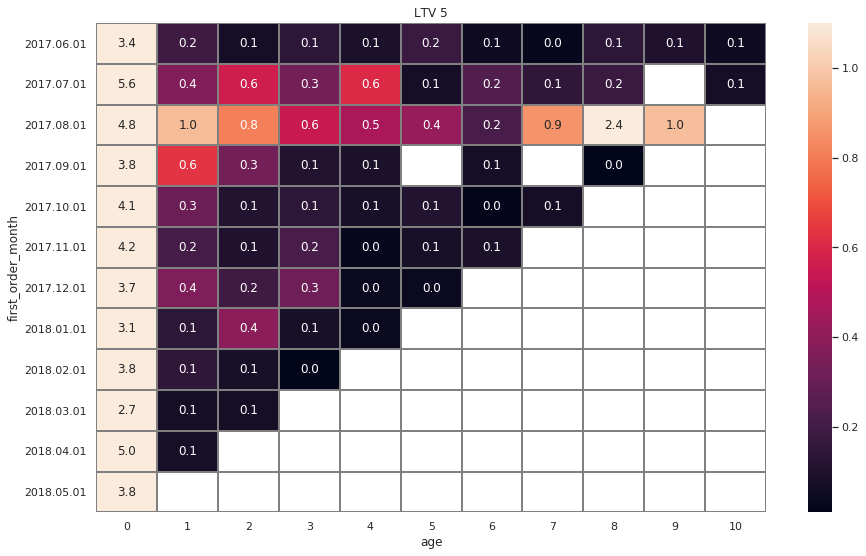

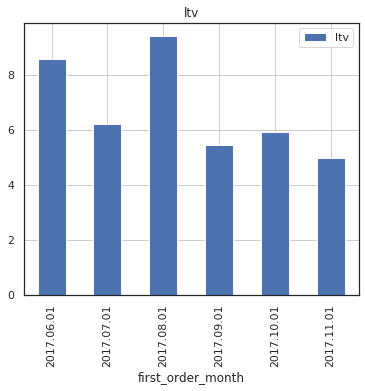

In [90]:
#срез по источнику 9
S1= final.query('source_id == "9"')

#посчитаем количество новых покупателей за каждый месяц
cohort_sizes = S1.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
#print(cohort_sizes.head())

#cгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
cohorts = S1.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
#print(cohorts.head())

#сгруппируем данные
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
#print(report.head())

#посчитаем ltv и возраст когорт
report['ltv'] = report['revenue'] / report['n_buyers']
report['first_order_month'] = report['first_order_month'].astype('datetime64[M]')
report['order_month'] = report['order_month'].astype('datetime64[M]')
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['first_order_month'] = report['first_order_month'].dt.strftime('%Y.%m.%d')
report['order_month'] = report['order_month'].dt.strftime('%Y.%m.%d')
#визуализируем когорты в виде сводной таблицы и построим график
orders_output = report.pivot_table(
        index='first_order_month',
        columns='age',
        values='ltv',
        aggfunc='mean').round(2)

sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('LTV 5')
sns.heatmap(orders_output, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmax=1.1)
#проанализируем когорты за 6 месяцев
orders_6_months.plot(grid=True, kind='bar', figsize=(6,5), title='ltv')
orders_6_months = report.query('age < 6 and first_order_month < "2017.12.01"').pivot_table(
        index='first_order_month',
        values='ltv',
        aggfunc='sum').round(2)
display(orders_6_months)
LTV9=float(orders_6_months.mean())
LTV9

,ltv
first_order_month,
2017.06.01,2.35
2017.07.01,3.36
2017.08.01,5.07
2017.09.01,2.74
2017.10.01,2.77
2017.11.01,4.74


3.5050000000000003

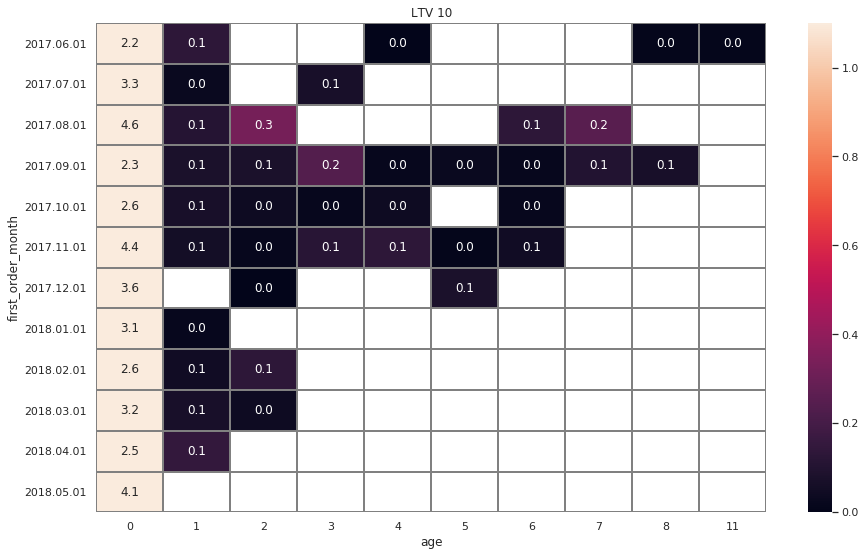

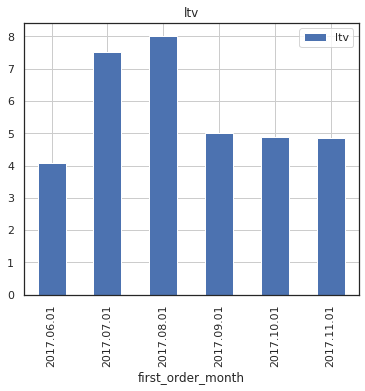

In [91]:
#срез по источнику 10
S1= final.query('source_id == "10"')

#посчитаем количество новых покупателей за каждый месяц
cohort_sizes = S1.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
#print(cohort_sizes.head())

#cгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
cohorts = S1.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
#print(cohorts.head())

#сгруппируем данные
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
#print(report.head())

#посчитаем ltv и возраст когорт
report['ltv'] = report['revenue'] / report['n_buyers']
report['first_order_month'] = report['first_order_month'].astype('datetime64[M]')
report['order_month'] = report['order_month'].astype('datetime64[M]')
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['first_order_month'] = report['first_order_month'].dt.strftime('%Y.%m.%d')
report['order_month'] = report['order_month'].dt.strftime('%Y.%m.%d')
#визуализируем когорты в виде сводной таблицы и построим график
orders_output = report.pivot_table(
        index='first_order_month',
        columns='age',
        values='ltv',
        aggfunc='mean').round(2)

sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('LTV 10')
sns.heatmap(orders_output, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmax=1.1)


#проанализируем когорты за 6 месяцев
orders_6_months.plot(grid=True, kind='bar', figsize=(6,5), title='ltv')
orders_6_months = report.query('age < 6 and first_order_month < "2017.12.01"').pivot_table(
        index='first_order_month',
        values='ltv',
        aggfunc='sum').round(2)
display(orders_6_months)
LTV10=float(orders_6_months.mean())
LTV10


**Рассчет roi по источникам**

In [92]:
#cac_pivot_mean

Добавим в таблицу cac_pivot_mean со средним САС по источникам средений ltv за 6 месяцев по источникам

In [93]:
output_romi = cac_pivot_mean
output_romi['ltv'] = [LTV1, LTV2, LTV3, LTV4, LTV5, LTV9, LTV10]
output_romi['roi'] = (output_romi['ltv']/output_romi['cac']).round(2)
output_romi

,cac,ltv,roi
source_id,,,
1,5.599167,11.541667,2.06
2,10.088333,18.051667,1.79
3,15.884167,5.445000,0.34
4,6.687500,6.113333,0.91
5,7.554167,6.761667,0.90
9,4.300833,5.726667,1.33
10,5.260000,3.505000,0.67


- Наиболее высокие значения ltv в 1 и 2 источниках
- рентабельными являются источники 1,2,9
- наибольший убыток приносят источники 3 (roi=0.34) и 10 (roi=0.67) - их следует отключить в первую очередь

**Расчитаем метрики по категориям устройств**

In [94]:
#сформируем таблицу со средним чеком устройств
visits_sorted = visits.sort_values(by='session_start_ts').reset_index()
first_source = visits.groupby(['Uid', 'device']).agg({'source_id': 'first'}).reset_index()
client_per_source = orders.merge(first_source, on='Uid').reset_index()
source_clients_month = client_per_source.groupby(['device']).agg({'revenue': 'sum', 'buy_ts': 'count'})
source_clients_month['rev_purch']=source_clients_month['revenue']/source_clients_month['buy_ts']
source_clients_month[['rev_purch']]

,rev_purch
device,
desktop,5.197312
touch,4.785987


In [95]:
d=5.197312-4.785987
d

0.4113249999999997

In [96]:
#сформируем таблицу со средней длинной и числом сессий устройств
device=visits.groupby(['device']).agg({'session_duration_sec': 'mean', 'session_start_ts': 'count'})
device.columns = ['duration_sec', 'count_sec']
device

,duration_sec,count_sec
device,,
desktop,703.946977,262567
touch,479.619407,96833


Средний чек у desktop на 0,41 выше, чем у touch. Сервисом гораздо активнее пользуются с desktop, чем с touch. Возможно стоит улучшить мобильную версию.

## 2.3. Вывод

- Совокупные затраты на маркетинг составляют 329 131.62,
- Наибольшие затраты (141321.63), составляющие почти половину всех затрат на маркетинг, направлены на рекламный источник с идентификатором 3,
- Наиболее высокие значения ltv в 1 и 2 источниках,
- рентабельными являются источники 1,2,9 на временном отрезке в 6 месяцев,
- наибольший убыток приносят источники 3 (roi=0.34) и 10 (roi=0.67) - их следует отключить в первую очередь,
- Средний чек у desktop на 0,41 выше, чем у touch. Сервисом гораздо активнее пользуются с desktop, чем с touch. Возможно стоит улучшить мобильную версию.

## 3. <a name="6."></a>Общий вывод
[к содержанию](#7.)

- Аудитория сервиса составляет **907** уникальных активных пользователя в день, **5716** в неделю и **23228** в месяц,
- в среднем на 1 пользователя приходится **1** сессия в день продолжительностью **60** сек,
- медианное время от первой сессии до заказа **22 минуты**,
- cредний чек сервиса составляет **4,84**,
- наиболее высокие значения ltv в 1 и 2 источниках,
- рентабельными являются источники 1,2,9 на временном отрезке в 6 месяцев,
- наибольший убыток приносят источники 3 (roi=**0.34**) и 10 (roi=**0.67**) - их следует отключить в первую очередь,
- средний чек у desktop на 0,41 выше, чем у touch. Сервисом гораздо активнее пользуются с desktop, чем с touch. 